In [11]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.relativedelta import relativedelta

In [12]:
import wmfdata as wmf

In [13]:
%matplotlib inline

mpl.rcParams["font.size"] = 16
mpl.rcParams["figure.figsize"] = (14, 7)
mpl.rcParams["axes.grid"] = True

def M_str(x, pos):
    n = int(round(x / 1000000))
    return "{n} M".format(n=n)

pct_fmt = mpl.ticker.PercentFormatter(xmax=1)
M_fmt = mpl.ticker.FuncFormatter(M_str)
comma_fmt = mpl.ticker.StrMethodFormatter("{x:,.0f}")

# New editors

In [14]:
proj_mo_new = wmf.hive.run("""
    select
        dt as d,
        wiki_db as wiki,
        value as new_eds
    from wmf.mediawiki_metrics
    where 
        metric = "monthly_new_editors" and
        snapshot = "2018-04"
""")

In [15]:
proj_mo_new["d"] = pd.to_datetime(proj_mo_new["d"])

In [16]:
glob_new = proj_mo_new.groupby("d")["new_eds"].sum()

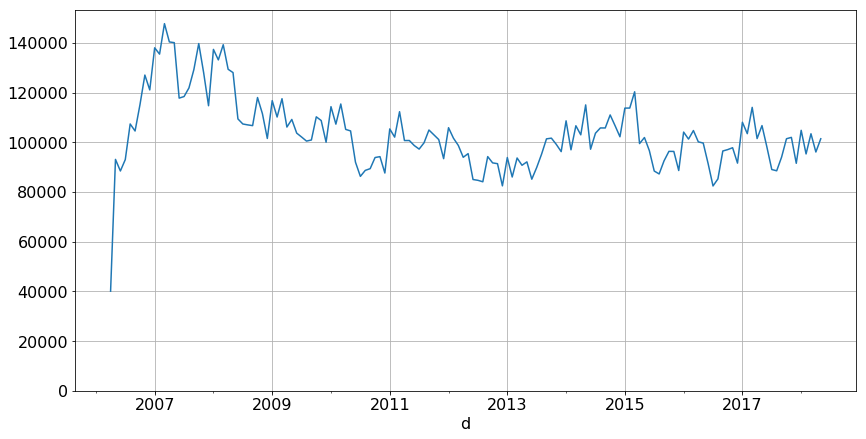

In [17]:
glob_new.plot(ylim=0);

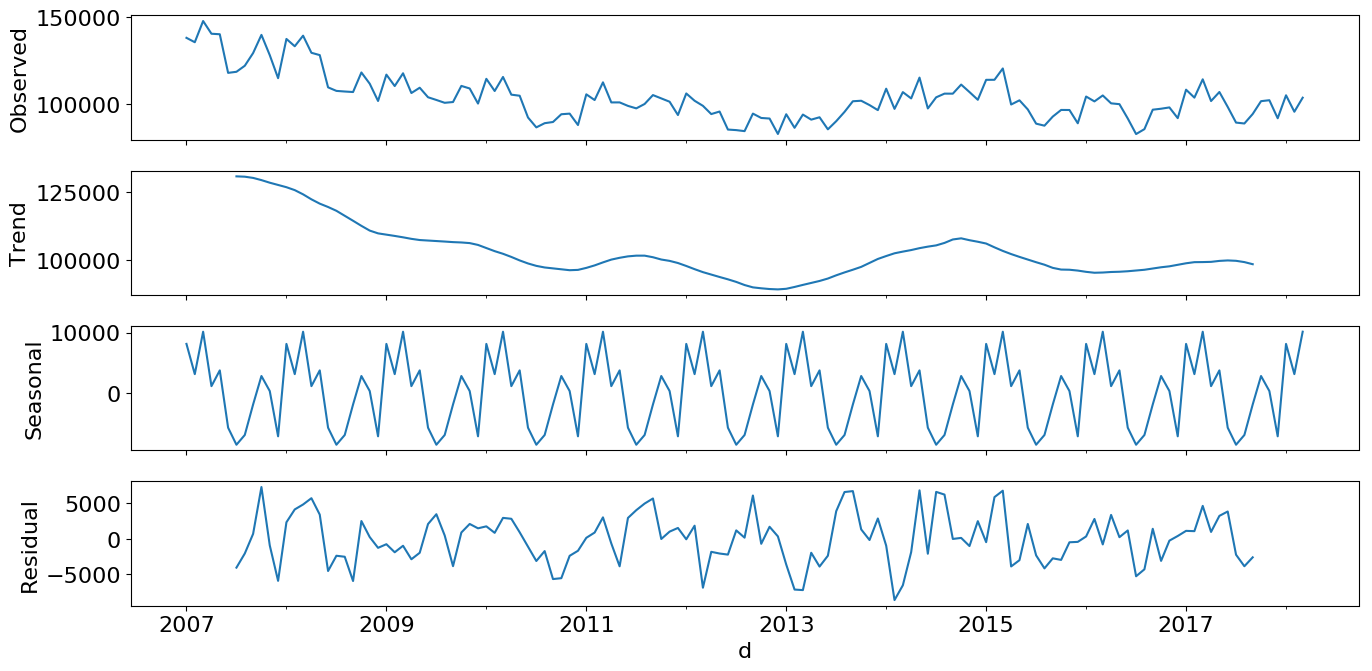

In [13]:
result = seasonal_decompose(glob_new["2007":], model='additive')
result.plot();

# New *active* editors

In [91]:
new_act = wmf.mariadb.run("""
    select 
    month,
    wiki,
    sum(extract(year_month from user_registration) = extract(year_month from month)) as new_actives
    from staging.editor_month
    where
    month >= "2013-01-01" and
    content_edits >= 5 and
    local_user_id != 0 and
    bot_flag = 0 and (
        convert(user_name using utf8) not regexp "bot\\\\b" or
        user_name in ("Paucabot", "Niabot", "Marbot")    
    )
    group by month, wiki
""")

new_act["month"] = new_act["month"].apply(pd.to_datetime)
new_act = new_act.set_index(["wiki", "month"])

new_act.head()

,,new_actives
wiki,month,
acewiki,2013-01-01,0.0
adywiki,2013-01-01,0.0
afwiki,2013-01-01,8.0
alswiki,2013-01-01,1.0
amwiki,2013-01-01,0.0


In [100]:
# Fill in missing zero-value rows
wikis = new_act.index.unique(level="wiki")
mos = new_act.index.unique(level="month")

wiki_mo_idx = pd.MultiIndex.from_product([wikis, mos], names=['wiki', 'month'])
new_act = new_act.reindex(wiki_mo_idx, fill_value=0)

In [18]:
new_act

NameError: name 'new_act' is not defined

# Global new and new active

In [25]:
glob_new = wmf.hive.run("""
select
    date_format(event_user_creation_timestamp, "yyyy-MM-01") as mon,
    count(*) as new_editors,
    sum(cast(30_d_content_edits >= 5 as int)) as new_active_editors
from (
    select
        event_user_creation_timestamp,
        count(*) as 30_d_edits,
        sum(cast(page_namespace_is_content_historical as int)) as 30_d_content_edits
    from wmf.mediawiki_history
    where 
        snapshot = "2018-06" and
        event_entity = "revision" and
        event_type = "create" and
        not (event_user_is_bot_by_name or array_contains(event_user_groups, "bot")) and
        not event_user_is_anonymous and
        not event_user_is_created_by_system and
        event_timestamp <= date_add(event_user_creation_timestamp, 30)
    group by user_text, event_user_creation_timestamp
) day_30
group by date_format(event_user_creation_timestamp, "yyyy-MM-01")
""")

In [27]:
glob_new.tail()

,mon,new_editors,new_active_editors
205,2018-02-01,101023,12916
206,2018-03-01,110479,14585
207,2018-04-01,102329,13087
208,2018-05-01,107333,14772
209,2018-06-01,92321,11283


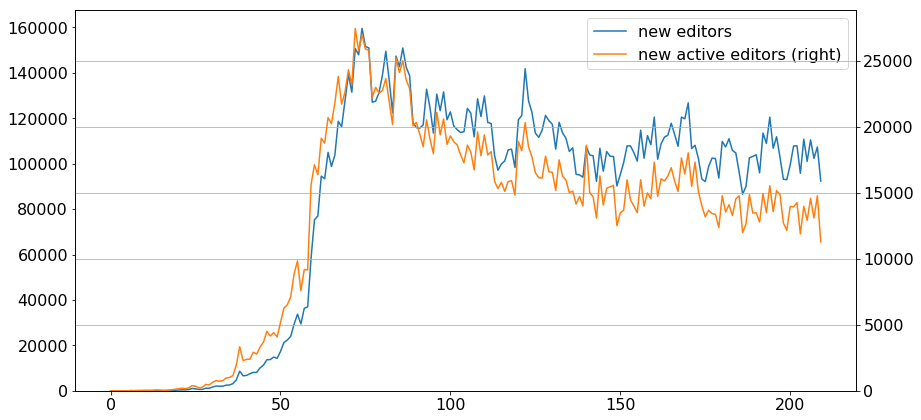

In [32]:
ax = glob_new["new_editors"].plot(label="new editors", legend=True, ylim=0)
glob_new["new_active_editors"].plot(secondary_y=True, label="new active editors", legend=True)
ax.right_ax.set_ylim(0);

# Gainer and loser wikis

In [111]:
cur_mo = new_act.index.unique(level="month").max().to_pydatetime()
cur_yr = pd.date_range(end=cur_mo, periods=12, freq="MS")
base_mo = cur_mo - relativedelta(years=3)
base_yr = pd.date_range(end=base_mo, periods=12, freq="MS")

print("Base year:", cur_yr[0], "–", cur_yr[-1])
print("Current year:", base_yr[0], "–", base_yr[-1])

Base year: 2017-05-01 00:00:00 – 2018-04-01 00:00:00
Current year: 2014-05-01 00:00:00 – 2015-04-01 00:00:00


In [106]:
r_new_act = new_act.groupby(level="wiki").apply(lambda x: x.rolling(12).mean())

In [155]:
def long_term_change(df):
    df = df.reset_index(level=0, drop=True)
    return df.loc[cur_mo] - df.loc[base_mo]

change = r_new_act.groupby(level="wiki").apply(long_term_change).sort_values(by="new_actives", ascending=False).dropna()

In [157]:
display(change.head(10))
display(change.tail(10))

,new_actives
wiki,
wikidatawiki,378.500000
commonswiki,105.083333
fawiki,89.666667
tawiki,75.416667
etwiki,24.333333
hiwiki,19.750000
mrwiki,18.916667
bnwiki,15.416667
zh_yuewiki,14.916667


,new_actives
wiki,
kowiki,-88.083333
arwiki,-88.583333
zhwiki,-122.916667
itwiki,-131.583333
ruwiki,-161.500000
ptwiki,-176.333333
dewiki,-198.500000
trwiki,-234.833333
eswiki,-446.250000


# Seasonal analysis

In [ ]:
monthly_new = wmf.mariadb.run("""
    select 
        month, 
        sum(extract(year_month from reg) = extract(year_month from month)) as new_active_editors
    from (
        select 
            month, user_name, sum(content_edits) as content_edits, 
            min(user_registration) as reg, max(bot_flag) as bot_flag
        from staging.editor_month
        where local_user_id != 0
        group by month, user_name
    ) global_edits
    where
        content_edits >= 5 and 
        bot_flag = 0 and
        convert(user_name using utf8) not regexp "bot\\b" and
        convert(user_name using utf8) not regexp "[ _]bot[ _]"
    group by month
""")

In [37]:
monthly_new = monthly_new.set_index(pd.DatetimeIndex(monthly_new["month"])).drop("month", axis = 1)

In [38]:
monthly_new.head()

,new_active_editors
month,
1970-01-01,0.0
2001-01-01,4.0
2001-02-01,3.0
2001-03-01,9.0
2001-04-01,1.0


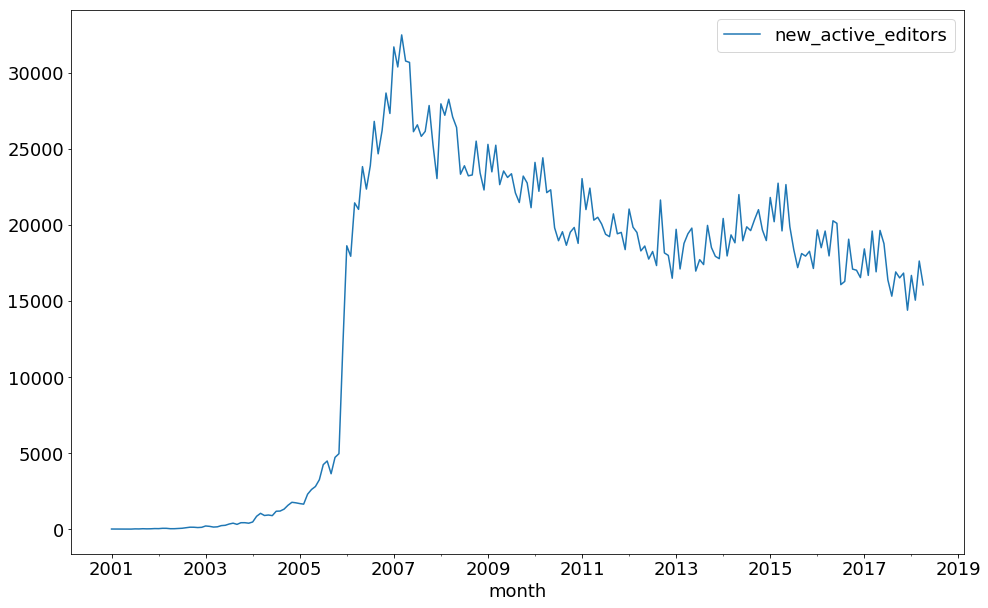

In [41]:
monthly_new.plot();

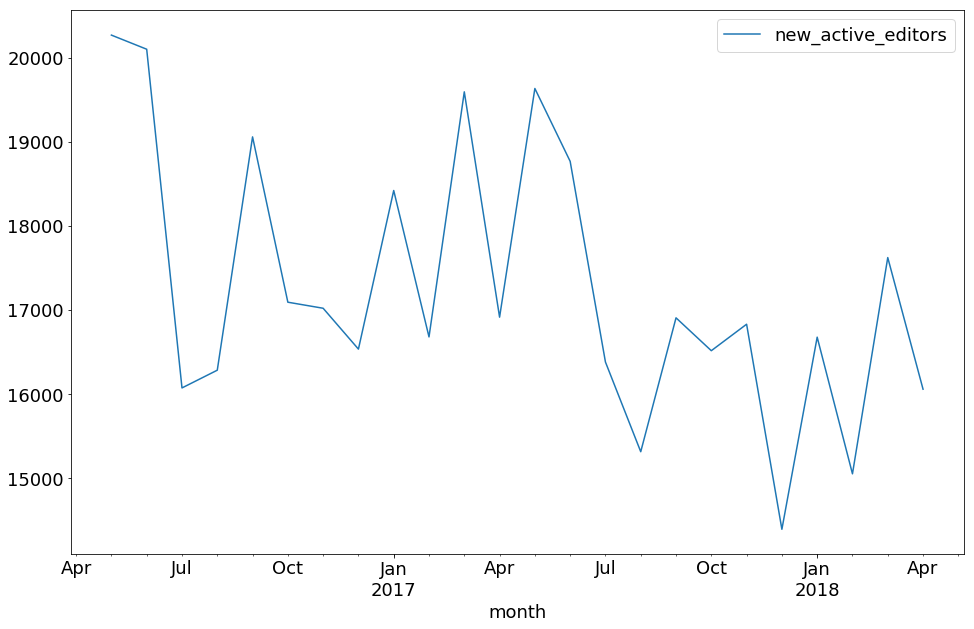

In [45]:
monthly_new["2016-05-01":].plot()

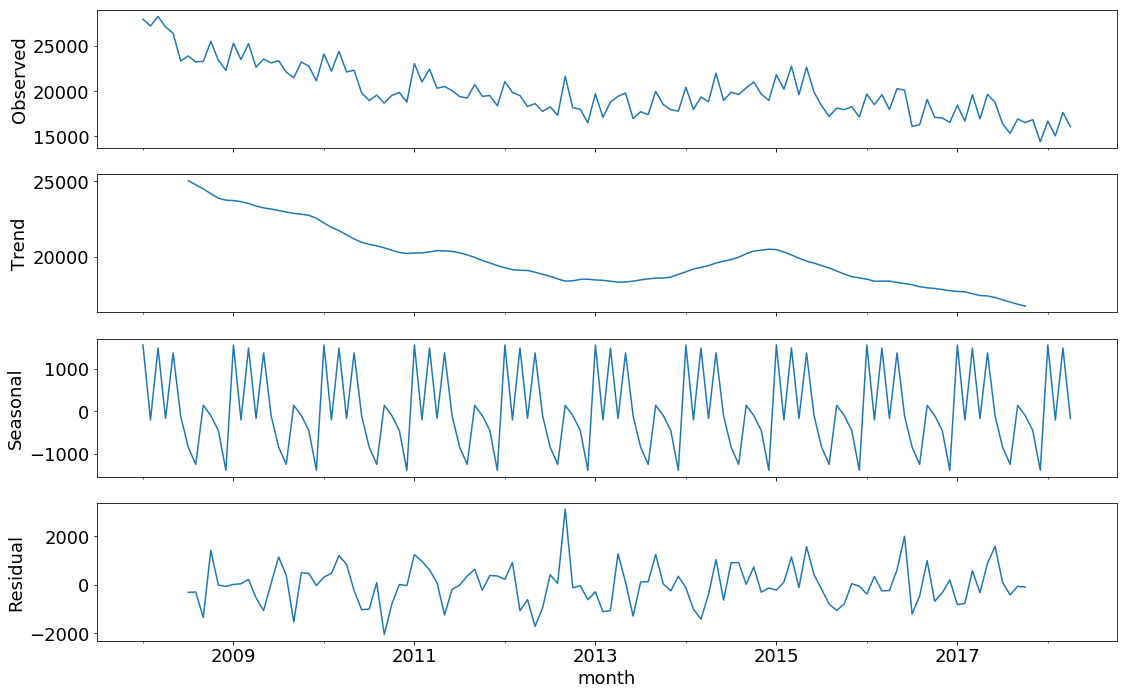

In [42]:
new_act_decomp = seasonal_decompose(monthly_new.loc["2008-01-01":], model='additive')
new_act_decomp.plot();

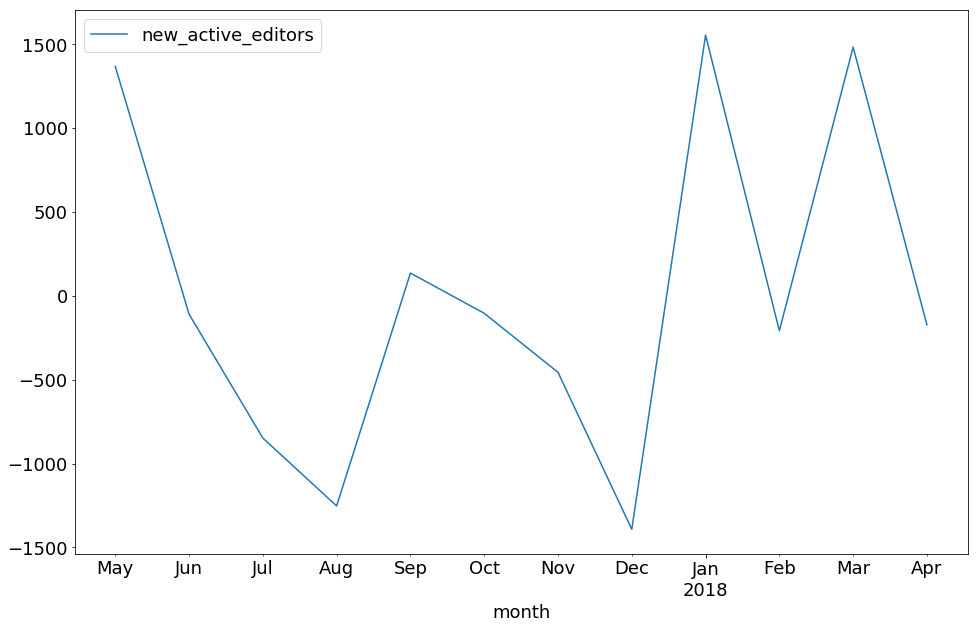

In [43]:
new_act_decomp.seasonal.tail(12).plot()

# Wikipedia new editor retention

In [8]:
proj_ret = wmf.hive.run(
    """
    select 
        wiki,
        cohort as reg_mo,
        count(*) as new_eds,
        (sum(if(2nd_month_edits >= 1, 1, 0)) / sum(if(1st_month_edits >= 1, 1, 0))) as ret
    from neilpquinn.new_editors
    group by wiki, cohort
    order by wiki, cohort asc
    limit 250000
    """
)

In [10]:
wikipedias = wmf.utils.list_wikis(["wikipedia"])

def segment(w):
    if w == "enwiki":
        return "English Wikipedia"
    elif w in wikipedias:
        return "Other Wikipedias"
    else:
        return "Other projects"

proj_ret["group"] = proj_ret["wiki"].apply(segment)

In [25]:
def avg_ret(df):
    return (df["new_eds"] * df["ret"]).sum() / df["new_eds"].sum()

wp_ret = proj_ret.query("group != 'Other projects'")
wp_ret = pd.DataFrame(wp_ret.groupby(["group", "reg_mo"]).apply(avg_ret)).reset_index().pivot("reg_mo", "group")
wp_ret.columns = wp_ret.columns.droplevel(0)
wp_ret.index = pd.to_datetime(wp_ret.index)

wp_ret.tail()

group,English Wikipedia,Other Wikipedias
reg_mo,,
2017-12-01,0.050015,0.057985
2018-01-01,0.099836,0.060285
2018-02-01,0.075447,0.061999
2018-03-01,0.067049,0.064500
2018-04-01,0.057509,0.059625


In [55]:
wp_ret["2003":].plot(ylim=0, title="new Wikipedia editor retention")
plt.ylabel("retention rate")
plt.xlabel("")
ax = plt.gca()
ax.legend().set_title("")
ax.yaxis.set_major_formatter(pct_fmt)
plt.autoscale(enable=True, axis="x", tight=True);

TypeError: cannot do slice indexing on <class 'pandas.core.indexes.numeric.Int64Index'> with these indexers [2001] of <class 'str'>

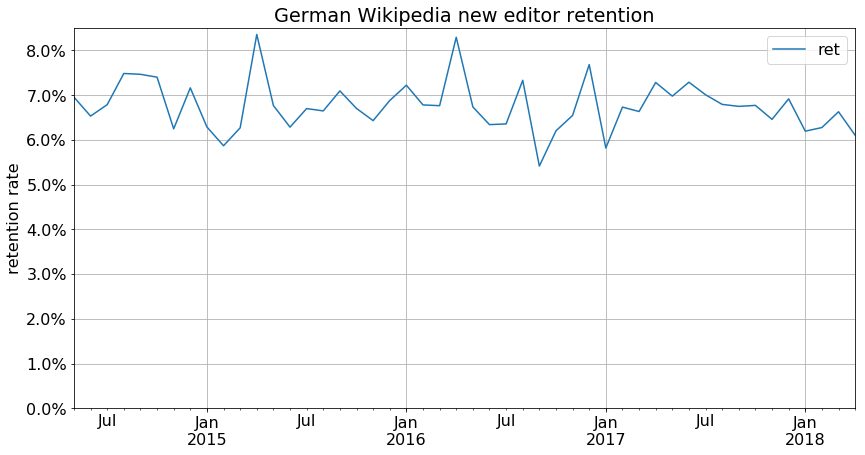

In [57]:
de_ret = proj_ret.query("wiki == 'dewiki'")
de_ret.set_index(pd.to_datetime(de_ret["reg_mo"]), drop=True)["ret"]["2014-05":].plot(ylim=0, title="German Wikipedia new editor retention")
plt.ylabel("retention rate")
plt.xlabel("")
ax = plt.gca()
ax.legend().set_title("")
ax.yaxis.set_major_formatter(pct_fmt)
plt.autoscale(enable=True, axis="x", tight=True)
plt.savefig("dewiki.png");

In [59]:
de_ret.to_csv("dewiki_ret.tsv", sep="\t", index=False)

# Additional things to investigate:
* Correlation between size of new editor cohort and its retention?
* Correlations between registrations and new editors?